## 2021 금융데이터 경진대회 : 개미는 뚠뚠뚠 팀
### [[4. 추천서비스 구현 ]]
##### 목차
##### 1. 패키지 불러오기
##### 2. 추천시스템1 : 친구개미 초이스(Choice)
##### 3. 추천시스템2 : 슈퍼개미로 한걸음
##### 4. 금융트랜드 분석1 : 금융트랜드 알리미 - 금융트랜드분석
##### 5, 금융트랜드 분석2 : 금융트랜드 알리미 - 연관어 분석
##### 6. PoC : 추천서비스 구현

###### 맞춤 추천 서비스 실행 예시 페이지 1 : https://antddunddun.netlify.app/
###### 맞춤 추천 서비스 실행 예시 페이지 2: https://antddunddunddun.netlify.app/

### 1. 패키지 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
## 코드 제출 파일경로로 바꿔주세요
os.chdir("C:/Users/User/Desktop/분석코드_개미는뚠뚠뚠")

### 2. 추천시스템 1 : 친구개미 초이스(Choice)

In [3]:
##### : 투자 종목의 추천이 개인별 투자성향에 따라 이루어진다면, 선택에 큰 도움을 줄 수 있을 것입니다. 특히, 자신과 투자 성향이 
##### 비슷한 사람들이 많이 투자한 기업을 추천해준다면, 투자자의 기존 선호도에 기반하여 종목을 추천할 수 있을 것입니다.
##### 또한 자신이 보유하지 않은 종목을 추천 받을 수 있어, 포트폴리오의 다양성에 기여할 수 있을 것입니다. 본 분석에서는 맞춤 
##### 추천알고리즘을 구현하고자, 앞서 클러스터링을 통해 도출한 5개의 그룹과, 개인의 과거 거래종목을 활용하였습니다.

##### 1) 데이터 전처리

In [4]:
cl_data = pd.read_csv("data/id_cl_data.csv") #### R에서 클러스터링을 통해 만든 데이터입니다.
finance_df = pd.read_csv("data/재무지수_데이터.csv") #### 재무정보 크롤링을 통해 재무지수를 만든 데이터입니다.
data = pd.read_csv("data/2021금융데이터 경진대회_데이터셋_한국투자증권(원본).csv", encoding = 'CP949')

In [5]:
finance_df = finance_df.fillna(100) #### NaN가 있는 데이터는 지수 평균 100으로 채워줍니다.

In [6]:
finance_df = finance_df.astype({'수익성지수' : int, 
                 '성장성지수' : int,
                 '안정성지수' : int,
                 '활동성지수' : int}) #### 재무지수를 정수로 바꾸어줍니다.

In [7]:
data.head()

,고객구분코드,주문일자,고객성별구분코드,동일나이군구분코드,주소(시도),주문시간대,상품번호,상품명,거래소구분코드,매도매수구분코드,...,총체결금액,전일종가,당일시가,일중고가,일중저가,당일종가,거래수량,거래대금,상한가여부,하한가여부
0,A0001,20200128,1,30,경기,1,00000A091970,나노캠텍,3,2,...,75900,3215,3710,4125,3660,4095,17266597,6.732331e+10,N,N
1,A0001,20200130,1,30,경기,3,00000A045060,오공,3,2,...,154200,7690,8150,8380,7360,7920,15686931,1.250000e+11,N,N
2,A0001,20200313,1,30,경기,1,00000A253840,수젠텍,3,2,...,118000,13600,12200,12250,10150,10750,3731106,4.078277e+10,N,N
3,A00010,20200220,1,20,경남,3,00000A009190,대양금속보통주,2,2,...,49070,3615,3615,3675,3475,3505,635410,2.250893e+09,N,N
4,A000100,20200211,2,40,서울,1,00000A001740,SK네트웍스보통주,2,1,...,14625,4780,4800,4885,4800,4850,1263089,6.112027e+09,N,N


In [8]:
cl_data = cl_data[['id', 'cluster']]

In [9]:
#### 클러스터별 id 리스트 만들기
cl1_id = cl_data[cl_data['cluster']==1]['id'].tolist()
cl2_id = cl_data[cl_data['cluster']==2]['id'].tolist()
cl3_id = cl_data[cl_data['cluster']==3]['id'].tolist()
cl4_id = cl_data[cl_data['cluster']==4]['id'].tolist()
cl5_id = cl_data[cl_data['cluster']==5]['id'].tolist()

In [10]:
df = data[['고객구분코드','상품번호', '매도매수구분코드', '총체결금액']]
df.columns = ['id', 'stck_cd','purchase_cd', 'total_price']
df['stck_cd'] = [ i[-6:] for i  in df['stck_cd']] #### 종목코드가 6자리이므로 0을 채워 자릿수를 맞추어 줍니다.
df = df[df['purchase_cd']==2] #### 매수 데이터만 선택합니다.
trade_data = df[['id', 'stck_cd', 'total_price']]

<ipython-input-10-bc0a4ee49043>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stck_cd'] = [ i[-6:] for i  in df['stck_cd']] #### 종목코드가 6자리이므로 0을 채워 자릿수를 맞추어 줍니다.


In [11]:
trade_data['trade_ratio'] = trade_data['total_price'].div(trade_data.groupby('id')['total_price'].transform(lambda x : x.sum()))
trade_data = trade_data[['id', 'stck_cd', 'trade_ratio']] #### 전체매수금액으로 나누어 종목별 매수 금액 비율을 계산합니다.

In [12]:
trade_data1 = trade_data.loc[trade_data['id'].isin(cl1_id)] #### 클러스터별로 데이터 나누어줍니다.
trade_data2 = trade_data.loc[trade_data['id'].isin(cl2_id)]
trade_data3= trade_data.loc[trade_data['id'].isin(cl3_id)]
trade_data4 = trade_data.loc[trade_data['id'].isin(cl4_id)]
trade_data5 = trade_data.loc[trade_data['id'].isin(cl5_id)]

##### 2) 추천시스템 구현
##### : 클러스터별로 추천 시스템 구현합니다. 이후 추천 알고리즘에서 사용자의 클러스터에 맞게 추천시스템을 선택해 사용할 예정입니다.

In [13]:
### 클러스터1
trade_data_pivot1 = trade_data1.pivot_table('trade_ratio', index = 'id', columns = 'stck_cd')  #### 사용자ID를 기준으로 매수금액을 점수로한 Pivot 테이블을 생성합니다.
trade_data_pivot1.fillna(0, inplace = True) #### 매수내역이 없는 종목은 0으로 채워줍니다.
user_based_collabor1 = cosine_similarity(trade_data_pivot1) #### 사용자 간의 코사인유사도를 계산합니다.
user_based_collabor_data1 = pd.DataFrame(data = user_based_collabor1, 
                                        index = trade_data_pivot1.index, 
                                       columns = trade_data_pivot1.index) #### 앞에서 계산한 유사도를 사용하여 유사도 행렬을 계산합니다.
def similar_user1(user): #### 사용자 ID를 기준으로 유사도 행렬를 반환하는 함수를 만듭니다.
    return user_based_collabor_data1[user].sort_values(ascending=False) #### 입력받은 ID를 기준으로 유사도를 내림차순으로 정렬하여 결과를 반환합니다.

In [14]:
### 클러스터2
trade_data_pivot2 = trade_data2.pivot_table('trade_ratio', index = 'id', columns = 'stck_cd')
trade_data_pivot2.fillna(0, inplace = True)
user_based_collabor2 = cosine_similarity(trade_data_pivot2)
user_based_collabor_data2 = pd.DataFrame(data = user_based_collabor2, 
                                        index = trade_data_pivot2.index, 
                                       columns = trade_data_pivot2.index)
def similar_user2(user):
    return user_based_collabor_data2[user].sort_values(ascending=False)

In [15]:
### 클러스터3
trade_data_pivot3 = trade_data3.pivot_table('trade_ratio', index = 'id', columns = 'stck_cd')
trade_data_pivot3.fillna(0, inplace = True)
user_based_collabor3 = cosine_similarity(trade_data_pivot3)
user_based_collabor_data3 = pd.DataFrame(data = user_based_collabor3, 
                                        index = trade_data_pivot3.index, 
                                       columns = trade_data_pivot3.index)
def similar_user3(user):
    return user_based_collabor_data3[user].sort_values(ascending=False)

In [16]:
### 클러스터4
trade_data_pivot4 = trade_data4.pivot_table('trade_ratio', index = 'id', columns = 'stck_cd')
trade_data_pivot4.fillna(0, inplace = True)
user_based_collabor4 = cosine_similarity(trade_data_pivot4)
user_based_collabor_data4 = pd.DataFrame(data = user_based_collabor4, 
                                        index = trade_data_pivot4.index, 
                                       columns = trade_data_pivot4.index)
def similar_user4(user):
    return user_based_collabor_data4[user].sort_values(ascending=False)

In [17]:
### 클러스터5
trade_data_pivot5 = trade_data5.pivot_table('trade_ratio', index = 'id', columns = 'stck_cd')
trade_data_pivot5.fillna(0, inplace = True)
user_based_collabor5 = cosine_similarity(trade_data_pivot5)
user_based_collabor_data5 = pd.DataFrame(data = user_based_collabor5, 
                                        index = trade_data_pivot5.index, 
                                       columns = trade_data_pivot5.index)
def similar_user5(user):
    return user_based_collabor_data5[user].sort_values(ascending=False)

##### 3) 추천 알고리즘 함수 만들기
##### : 사용자 ID를 입력하면 투자성향이 비슷한 사람들이 많이 산 종목을 추천해주는 함수를 만듭니다.

In [18]:
cl_data.loc[(cl_data['cluster']==1), 'cluster']  = '한우물개미'
cl_data.loc[(cl_data['cluster']==2), 'cluster']  = '큰손개미'
cl_data.loc[(cl_data['cluster']==3), 'cluster']  = '안정개미'
cl_data.loc[(cl_data['cluster']==4), 'cluster']  = '주린이개미'
cl_data.loc[(cl_data['cluster']==5), 'cluster']  = '한방개미'

In [19]:
## 추천알고리즘 함수 만들기
def Recommendation_system1(userid): #### 입력값으로 사용자 ID를 받습니다.
    cluster = cl_data[cl_data['id']==userid].reset_index()['cluster'][0] #### 사용자의 클러스터에 맞게 추천시스템에 사용할 투자자내역을 필터링합니다.
    if cluster == '한우물개미': #### 조건문을 사용해 클러스터에 맞게 위에서 만든 추천시스템을 사용합니다.
        user_list = similar_user1(userid)
    elif cluster  == '큰손개미':
        user_list = similar_user2(userid)
    elif cluster == '안정개미':
        user_list = similar_user3(userid)
    elif cluster == '주린이개미':
        user_list = similar_user4(userid)
    elif cluster == '한방개미':
        user_list = similar_user5(userid)
    
    user_list = user_list.reset_index()
    user_list = user_list[user_list['id']!=userid] #### 자기자신은 제외합니다. 자기자신은 코사인유사도가 가장 높습니다.
    user_list = user_list[user_list[userid]<1] #### 이외에도 코사인유사도가 1미만인 사람을 선택합니다.
    user_list = user_list[:10].reset_index() #### 유사도가 비슷한 상위 10명의 ID를 선택합니다.
    similar_id = user_list['id'].tolist()
    
    
    recom_stck = trade_data.loc[trade_data['id'].isin(similar_id)].groupby('stck_cd').sum().reset_index() #### 유사도가 높은 사람들의 거래내역을 종목코드를 기준으로 합산해줍니다.
    have_stck = trade_data[trade_data['id'] == userid].stck_cd.tolist() #### 거래내역에서 자기자신이 거래한 종목코드를 리스트로 만듭니다.
    recom_stck = recom_stck[-recom_stck['stck_cd'].isin(have_stck)].reset_index(drop = True) #### 추천 항목에서 자기자신이 거래한 항목은 제외합니다.
    recom_stck_cd = recom_stck.sort_values(ascending=False, by = 'trade_ratio')[:10]['stck_cd'].tolist() #### 거래비율이 높은 거래내역을 기준으로 정렬 후 상위 10개의 종목을 뽑습니다.
    
    result = finance_df.loc[finance_df['종목코드'].isin(recom_stck_cd)] #### 추천종목을 재무지수와 함께 반환합니다.
    result = result.reset_index(drop = True)
    
    return result
    

##### 4) 예시

In [20]:
Recommendation_system1('A00010038')

,종목코드,종목명,업종명,시장구분,수익성지수,성장성지수,안정성지수,활동성지수
0,217730,강스템바이오텍,제약,KOSDAQ,72,16,88,61
1,084650,랩지노믹스,기타서비스,KOSDAQ,222,126,71,128
2,059090,미코,반도체,KOSDAQ,125,125,108,81
3,200780,비씨월드제약,제약,KOSDAQ,121,82,70,64
4,253840,수젠텍,의료·정밀기기,KOSDAQ,105,96,190,133
5,174900,앱클론,제약,KOSDAQ,77,64,77,163
6,041960,코미팜,제약,KOSDAQ,113,71,50,58
7,005930,삼성전자,전기전자,KOSPI,134,95,80,76
8,011000,진원생명과학,의약품,KOSPI,-55,23,65,25
9,180640,한진칼,운수창고업,KOSPI,53,22,36,59


### 3. 추천시스템 2 : 슈퍼개미로 한걸음

In [21]:
##### : 주식을 안정적으로 투자하기 위해서는 투자종목 리스크 관리가 중요합니다. 그러나 신규 투자자가 자신의 포트폴리오를 분석하고 
##### 관리하는 것은 쉽지 않은 일입니다. 따라서 사용자의 포트폴리오를 분석 후 한눈에 분석결과를 확인하는 서비스를
##### 구현하고자 했습니다. 더불어 이를 기반으로 투자종목을 추천하는 것이 투자자의 합리적 투자결정에 도움이 될 것이라 판단하였습니다. 
##### 따라서 앞서 도출한 재무지수를 활용하여 개인 포트폴리오 맞춤 추천알고리즘을 제안하고자 합니다.

##### 1) 패키지 불러오기

In [22]:
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import random
import matplotlib.pyplot as plt

In [23]:
### 한글 폰트 사용을 하기위하여 설정을 바꾸어줍니다.
from matplotlib import font_manager, rc
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

##### 2) 데이터 불러오기

In [24]:
cl_data = pd.read_csv("data/id_cl_data.csv") #### R에서 클러스터링을 통해 만든 데이터입니다.
dat = pd.read_csv("data/재무지수_데이터.csv") #### 재무정보 크롤링을 통해 재무지수를 만든 데이터입니다.
data = pd.read_csv("data/2021금융데이터 경진대회_데이터셋_한국투자증권(원본).csv", encoding = 'CP949')

##### 3) 데이터 전처리

In [25]:
dat = dat.fillna(100) #### NaN가 있는 데이터는 지수 평균 100으로 채워줍니다.

In [26]:
dat = dat.astype({'수익성지수' : int, 
                 '성장성지수' : int,
                 '안정성지수' : int,
                 '활동성지수' : int}) #### 재무지수를 정수로 바꾸어줍니다.

In [27]:
dat.head(5)

,종목코드,종목명,업종명,시장구분,수익성지수,성장성지수,안정성지수,활동성지수
0,060310,3S,기계·장비,KOSDAQ,122,64,78,25
1,054620,APS홀딩스,금융,KOSDAQ,57,75,85,-72
2,265520,AP시스템,반도체,KOSDAQ,133,90,124,133
3,211270,AP위성,통신장비,KOSDAQ,117,38,76,38
4,035760,CJ ENM,방송서비스,KOSDAQ,132,103,76,66


In [28]:
#### 고객정보데이터에 컬럼이름을 바꾸어줍니다.
cl_data.rename(columns = { 'Factor1':'거래참여지수' , 
                          'Factor2' : '민감도지수' , 
                          'Factor3' : '분산투자지수', 
                          'Factor4' : '성장기대지수' ,
                          'purchase_ratio' : '매수비율'}, inplace = True)

In [29]:
cl_data.loc[(cl_data['cluster']==1), 'cluster']  = '한우물개미'
cl_data.loc[(cl_data['cluster']==2), 'cluster']  = '큰손개미'
cl_data.loc[(cl_data['cluster']==3), 'cluster']  = '안정개미'
cl_data.loc[(cl_data['cluster']==4), 'cluster']  = '주린이개미'
cl_data.loc[(cl_data['cluster']==5), 'cluster']  = '한방개미'

In [30]:
cl_data.head()

,id,cluster,거래참여지수,민감도지수,분산투자지수,성장기대지수,매수비율,age,trade_cnt,trade_sum_p,trade_sum_amt,stck_cnt,trade_date_cnt,kospi200_ratio,firm_up_ratio,trend_beta,finance_beta
0,A00010,한우물개미,-0.173647,0.049400,-0.102623,-1.160713,0.782411,20,15,927070.0,385,10,10,0.000000,0.000000,1.287436,1.833247
1,A000100,한방개미,-0.077895,0.313378,-0.187606,1.525009,0.819261,40,14,14770590.0,782,10,10,0.289373,0.862890,15.512479,-13.590063
2,A0001000,한방개미,-0.143942,-0.330784,-0.456871,1.048056,0.749392,30,11,1632487.0,372,6,6,0.000000,0.713176,-6.988161,13.976306
3,A00010000,안정개미,0.236377,0.032284,0.015679,0.038619,0.652059,20,27,27507090.0,17574,12,15,0.379910,0.369087,-0.233503,2.719544
4,A00010002,한우물개미,-0.128243,0.023497,-0.378626,-0.427637,0.774041,20,12,2708450.0,150,6,11,0.396832,0.233713,-1.212641,2.716332


In [31]:
cluster_info = cl_data.groupby('cluster').mean().reset_index() #### 클러스터별로 변수의 평균 데이터를 만듭니다.

In [32]:
cluster_info

,cluster,거래참여지수,민감도지수,분산투자지수,성장기대지수,매수비율,age,trade_cnt,trade_sum_p,trade_sum_amt,stck_cnt,trade_date_cnt,kospi200_ratio,firm_up_ratio,trend_beta,finance_beta
0,안정개미,-0.070471,0.055695,-0.226522,-0.679423,0.560024,31.934666,22.905728,2.565445e+07,2288.882458,8.370823,10.396181,0.480826,0.155937,-1.056706,0.956560
1,주린이개미,0.144623,0.073716,1.349857,0.495708,0.556392,31.868410,96.369043,6.506573e+07,8225.320118,30.801771,21.986082,0.204123,0.523854,-0.326114,0.362577
2,큰손개미,1.405654,0.102457,1.249678,0.591394,0.525432,34.758454,117.608696,4.287422e+08,67348.541063,27.567633,23.751208,0.129185,0.568942,0.514273,-0.341220
3,한방개미,-0.057801,-0.101414,-0.190471,1.087770,0.591813,30.938154,22.948625,2.606503e+07,2508.583834,9.549490,9.559123,0.176386,0.724111,-2.867066,3.542004
4,한우물개미,-0.109134,0.065286,-0.378406,-0.791708,0.910293,32.956494,17.179686,1.009709e+07,739.443312,6.207343,9.599062,0.551315,0.119316,-0.419910,1.039542


In [33]:
cluster_info['id'] = ['cluster']*5

##### 4) 나의 거래성향을 보여주는 함수 만들기

In [34]:
def my_investment(user):
    global cl_dat
    global cluster_info
    my_data = cl_data[cl_data['id']==user].reset_index(drop = True)
    my_cluster_data = cluster_info[cluster_info['cluster']==my_data.cluster[0]]
    my_info = pd.concat([my_data,my_cluster_data ], axis = 0).reset_index(drop = True)
    return my_info

In [35]:
my_investment('A00010038')

,id,cluster,거래참여지수,민감도지수,분산투자지수,성장기대지수,매수비율,age,trade_cnt,trade_sum_p,trade_sum_amt,stck_cnt,trade_date_cnt,kospi200_ratio,firm_up_ratio,trend_beta,finance_beta
0,A00010038,주린이개미,0.045581,0.071251,1.601753,0.037759,0.470347,40.00000,181.000000,1.026678e+07,2496.000000,34.000000,18.000000,0.362709,0.385293,0.406579,-0.652711
1,cluster,주린이개미,0.144623,0.073716,1.349857,0.495708,0.556392,31.86841,96.369043,6.506573e+07,8225.320118,30.801771,21.986082,0.204123,0.523854,-0.326114,0.362577


##### 5) 사용자 포트폴리오 재무점수 함수 만들기

In [36]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [37]:
def my_stck_score_plot(user): #### 사용자 id를 입력변수로 받습니다.
    
    global data
    
    ## 사용자 포트폴리오의 재무점수를 계산합니다.
    trade_data = data[(data['고객구분코드']==user) & (data['매도매수구분코드']==2)][['상품번호', '총체결금액']] #### 전체 거래내역에서 사용자의 id와 일치하면서 매수거래내역만 선택합니다.
    trade_dat = trade_data.groupby('상품번호').sum().reset_index() #### 상품번호를 기준으로 총체결금액을 합산합니다.
    trade_dat['총체결금액'] = trade_dat['총체결금액']/sum(trade_dat['총체결금액']) #### 종목별 거래금액을 전체 거래금액으로 나누어 비율을 계산합니다.
    stck_list = trade_dat['상품번호'].tolist() #### 거래한 종목을 리스트로 만듭니다.
    stck_list = [i[-6:] for i in stck_list] #### 종목코드는 6자리기 때문에 0을채워 자릿수를 맞추어줍니다.
    trade_dat['상품번호'] = stck_list 
    my_stck_score = dat[dat['종목코드'].isin(stck_list)] #### 거래한 종목의 재무지수를 불러옵니다.
    my_stck_score = pd.merge(trade_dat, my_stck_score, how = 'left', left_on = '상품번호' , right_on = '종목코드') #### 내가 거래한 내역과 재무지수를 조인합니다.
    
    profit_score = sum(my_stck_score['총체결금액'] * my_stck_score['수익성지수']) #### 종목별 매수거래금액비율을 가중치로 하여 사용자 포트폴리오의 수익성지수를 계산합니다.
    growth_score = sum(my_stck_score['총체결금액'] * my_stck_score['성장성지수']) #### 종목별 매수거래금액비율을 가중치로 하여 사용자 포트폴리오의 성장성지수를 계산합니다.
    stability_score = sum(my_stck_score['총체결금액'] * my_stck_score['안정성지수']) #### 종목별 매수거래금액비율을 가중치로 하여 사용자 포트폴리오의 안정성지수를 계산합니다.
    activity_score = sum(my_stck_score['총체결금액'] * my_stck_score['활동성지수']) #### 종목별 매수거래금액비율을 가중치로 하여 사용자 포트폴리오의 활동성지수를 계산합니다.
    
    
    my_score = [[profit_score, growth_score, stability_score, activity_score]] #### 사용자 포트폴리오의 재무지수를 저장합니다.
    
    my_stck_score = pd.DataFrame(my_score, columns = ['수익성지수', '성장성지수', '안정성지수', '활동성지수'])
    my_stck_score['종합지수'] = np.mean(my_stck_score.iloc[0].tolist())
     
    
    ## 사용자 포트폴리오의 재무점수를 레이더차트로 시각화합니다.
    
    #### 레이더 차트에 예쁘게 그리기 위해 재무지수를 0부터 150으로 맞추어줍니다.
    my_score_list = my_stck_score.iloc[0].tolist()
    for i in range(0, len(my_score_list)): 
        if my_score_list[i] >= 150 :
            my_score_list[i] = 150
        elif my_score_list[i] <= 0:
            my_score_list[i] = 0
    
    labels = my_stck_score.columns
    num_labels = len(labels) #### 라벨의 개수를 저장합니다.
    
    angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] #### 각 등분점을 계산합니다.
    angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가을 추가합니다.
    
    fig = plt.figure(figsize=(5,5))
    fig.set_facecolor('white')

    color = "#383275" #### 사용할 컬러를 지정합니다.
    df = my_score_list
    df += df[:1]
    
    ax = plt.subplot(polar=True)
    ax.set_theta_offset(pi / 2) ## 시작점입니다.
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향으로 설정합니다.
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨을 설정합니다.
    ax.tick_params(axis='x', which='major', pad=23) ## x축과 눈금 사이에 여백을 설정해줍니다.

    ax.set_rlabel_position(0) ## y축 각도 설정합니다.(degree 단위)
    plt.yticks([0, 25, 50, 75, 100,125,  150, 175, 200],['0','25', '50','75', '100', '125', '150','175', '200'], fontsize=10, color="grey") ## y축눈금 설정
    plt.ylim(0,150)
    
    ax.plot(angles, df, color=color, linewidth=2, linestyle='solid') ## 레이더 차트 출력합니다.
    ax.fill(angles, df, color=color, alpha=0.3) ## 도형 안쪽에 색을 채워줍니다.
    
    plt.show() #### 플랏을 보여줍니다.
    
    return my_stck_score #### 사용자 포트폴리오의 재무점수를 표로 반환합니다.

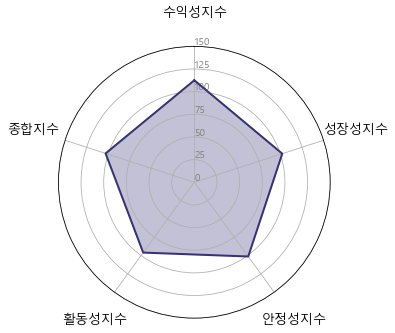

,수익성지수,성장성지수,안정성지수,활동성지수,종합지수
0,112.542009,102.077622,101.287738,95.980411,102.971945


In [38]:
my_stck_score_plot('A00010038')

##### 6) 추천알고리즘 만들기

In [39]:
#### 사용자 포트폴리오에서 부족한 재무지수를 찾습니다. 
#### 1의 값을 갖는 영역이 가장 부족한 영역, 2의 값을 갖는 영역이 두번재로 부족한 영역입니다. 
#### 이는 이후 추천 알고리즘에서 활용할 예정입니다.
def rank_return(my_rank_list):
    a = my_rank_list.index(1)
    a1 = my_rank_list.index(2)
    if a == 0 :
        b = '수익성지수'
    elif a == 1:
        b = '성장성지수'
    elif a == 2:
        b = '안정성지수'
    elif a == 3 :
        b = '활동성지수'
        
    if a1 == 0 :
        b1 = '수익성지수'
    elif a1 == 1:
        b1 = '성장성지수'
    elif a1 == 2:
        b1 = '안정성지수'
    elif a1 == 3 :
        b1 = '활동성지수'
    return b, b1

In [40]:
def Recommendation_system2(user): #### 사용자 아이디를 입력값으로 받습니다.
    
    global dat
    my_sc = my_stck_score_plot(user) #### 위에서 만든 함수를 사용하여 사용자 포트폴리오의 재무점수를 계산합니다.
    my_sc_rank = my_sc.rank(ascending = True, axis = 1).iloc[0, :].tolist() #### 재무점수를 부족한 순서대로 순위를 계산합니다.
    b, b1 =  rank_return(my_sc_rank) #### 부족한 재무영역를 저장합니다.
    dat_rank = dat.rank(axis = 1, ascending = False) #### 종목별 재무지수의 순위를 매깁니다.
    index_list = dat_rank[(dat_rank[b]==1) & (dat_rank[b1]==2)].index #### 사용자가 부족한 영역이 강점인 종목의 인덱스를 저장합니다.
    filter_dat = dat.iloc[index_list] #### 위에서 저장한 인덱스만 선택합니다.
    filter_dat = filter_dat[filter_dat[b]>100]
    filter_dat = filter_dat[filter_dat[b1]>100] #### 재무점수가 100이상인 것만 선택합니다.
    index_list2 = filter_dat.index
    rd_index = random.sample(list(index_list2), 10) #### 랜덤으로 기업 10개를 추천합니다.
    result = dat.iloc[rd_index].reset_index(drop = True)
    
    return result
    

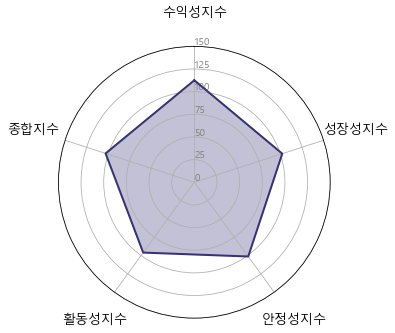

,종목코드,종목명,업종명,시장구분,수익성지수,성장성지수,안정성지수,활동성지수
0,323940,케이비제18호스팩,금융,KOSDAQ,25,82,103,130
1,051500,CJ프레시웨이,유통,KOSDAQ,89,33,124,155
2,036800,나이스정보통신,통신서비스,KOSDAQ,62,102,138,173
3,053590,한국테크놀로지,기계·장비,KOSDAQ,101,73,104,172
4,017810,풀무원,음식료품,KOSPI,88,94,106,151
5,027390,한화갤러리아타임월드,유통업,KOSPI,94,112,121,234
6,018260,삼성에스디에스,서비스업,KOSPI,106,89,108,156
7,076610,해성옵틱스,IT부품,KOSDAQ,-17,16,101,171
8,310840,엔에이치스팩13호,금융,KOSDAQ,24,82,102,130
9,032190,다우데이타,유통,KOSDAQ,150,149,289,363


In [41]:
Recommendation_system2('A00010038')

### 5. 금융트랜드 분석 1 : 금융트랜드 알리미- 금융트랜드분석

#### 1) 패키지 불러오기

In [42]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import os
import datetime

#### 2) 텍스트 전처리

In [43]:
df = pd.read_csv("data/뉴스기사 크롤링.csv")

In [44]:
df['date'] = [i[:10] for i in df['date']]
df['date'] = pd.to_datetime(df['date'])

In [45]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'+'↑↓▼▲◆·'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [46]:
okt = Okt()

In [47]:
def clean_punc(text, punct, mapping): #### 기호들을 제거하여 텍스트를 정제하는 함수를 만듭니다.
    for p in mapping: 
        text = text.replace(p, "") 
    for p in punct: 
        text = text.replace(p, "")
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials: 
        text = text.replace(s, "") 
    return text.strip()

#### 3) 금융 keyword 전처리

In [48]:
kosdaq = pd.read_csv('data/sector_kosdaq.csv', encoding = 'CP949')
kospi = pd.read_csv('data/sector_kospi.csv', encoding = 'CP949')
theme = pd.read_csv('data/테마주 및 업종명.csv')

In [49]:
word_list = kosdaq['업종명'].tolist() + kosdaq['종목명'].tolist() + kospi['업종명'].tolist() + kospi['종목명'].tolist()

In [50]:
word_list += theme['theme'].drop_duplicates().tolist()

#### 4) 금융 트랜드 분석

In [51]:
def tokenizer(raw_texts, pos=["Noun"], stopword=['금융'], saveword = word_list): #### 명사이면서 앞에서 지정한 불용어가 아닌 단어만 선택하는 함수입니다.
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word not in stopword  and word in saveword]
    j = " ".join(o) 
    return(j)

In [52]:
def fn_trend(from_date, to_date): #### 조회기간을 선택하여 뉴스에서 많이 나온 단어를 확인 가능합니다.
    global df
    a = pd.to_datetime(from_date)
    a1 =  pd.to_datetime(to_date)
    dat = df[(df['date'] > a) & (df['date'] < a1)]
    
    corpus = []
    for sent in dat['txt']:
        corpus.append(tokenizer(sent))
    
    word = []
    for i in range(0, len(corpus)):
        word += corpus[i].split(" ")
    counts = Counter(word)
    tags = counts.most_common()
    result = pd.DataFrame(tags)
    result.columns = ['단어', '출연횟수']
    result1 = result.head(10)
    
    return result1

In [53]:
fn_trend('20210901', '20210903') #### 9월 1일부터 4일까지 뉴스기사중 가장 많이 언급된 금융Word를 조회합니다.

,단어,출연횟수
0,원자력발전,64
1,증권,28
2,전선,20
3,카카오,15
4,코오롱,15
5,우진,15
6,남양유업,13
7,엔씨소프트,10
8,에이치엘비,5
9,대원,5


### 4. 금융트랜드 분석 2 : 금융트랜드 알리미- 연관어 분석

#### 1) 동시출현단어 프레임 만들기

In [54]:
#### 연관성 분석을 위해 동시 단어 출현횟수를 계산합니다.

In [55]:
def tokenizer1(raw_texts, pos=["Noun"], stopword=[]): #### 명사만 선택합니다.
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word not in stopword]
    return(o)

In [56]:
count = {} # 동시출현 빈도가 저장될 dict입니다.
for line in df['txt']:
    tokens = tokenizer1(line)
    stopped_tokens = [i for i in list(set(tokens))]
    stopped_tokens2 = [i for i in stopped_tokens if len(i)>1]
    for i,a in enumerate(stopped_tokens2):
        for b in stopped_tokens2[i+1:]:
            if a>b:
                count[b,a] = count.get((b,a),0) + 1
            else:
                count[a,b] = count.get((a,b),0) + 1

In [57]:
df1 = pd.DataFrame.from_dict(count, orient='index')

In [58]:
df1 = df1.reset_index()

In [59]:
df1['word1'] = [df1['index'][i][0] for i in range(0, len(df1))]
df1['word2'] = [df1['index'][i][1] for i in range(0, len(df1))]

In [60]:
df1['freq'] = df1.iloc[:,1]

In [61]:
data_set = df1[['word1', 'word2', 'freq']]

#### 2) 연관어 분석

In [62]:
import networkx as nx
import operator

In [63]:
import matplotlib.font_manager as fm

In [64]:
import matplotlib.pyplot as plt
 
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [65]:
def relataion_analysis(word): #### 선택한 단어의 연관성 분석 후 그래프를 그리는 함수를 만듭니다.
    global data_set
    dataset = data_set[(data_set['word1']==word )| (data_set['word2']==word)] #### 선택한 단어만 조회합니다.
    dataset = dataset.reset_index(drop = True)
    if __name__ == '__main__':
    
        G_centrality = nx.Graph()
    
        for ind in range((len(np.where(dataset['freq']>=30)[0]))):
            G_centrality.add_edge(dataset['word1'][ind], dataset['word2'][ind], weight = int(dataset['freq'][ind]))
        
        dgr = nx.degree_centrality(G_centrality)
        btw = nx.betweenness_centrality(G_centrality)
        cls = nx.closeness_centrality(G_centrality)
        egv = nx.eigenvector_centrality(G_centrality)
        pgr = nx.pagerank(G_centrality)
    
        sorted_dgr = sorted(dgr.items(), key = operator.itemgetter(1), reverse = True)
        sorted_btw = sorted(btw.items(), key = operator.itemgetter(1), reverse = True)
        sorted_cls = sorted(cls.items(), key = operator.itemgetter(1), reverse = True)
        sorted_egv = sorted(egv.items(), key = operator.itemgetter(1), reverse = True)
        sorted_pgr = sorted(pgr.items(), key = operator.itemgetter(1), reverse = True)
    
        G = nx.Graph()
    
        for i in range(len(sorted_pgr)):
            G.add_node(sorted_pgr[i][0], nodesize = sorted_dgr[i][1])
    
        for ind in range((len(np.where(dataset['freq']>30)[0]))):
            G.add_weighted_edges_from([(dataset['word1'][ind], dataset['word2'][ind], int(dataset['freq'][ind]))])
        
        #sizes = [G.nodes[node]['nodesize']*500 for node in G]
    
        options = {
            'edge_color' : "#e3e3e3", 
            'width':2, 
        'with_labels': True, 
        'font_weight' : 'regular'}
    
    
        fm._rebuild()
        font_fname = 'H2GTRE.TTF'
        fontprop = fm.FontProperties(fname = font_fname, size = 18).get_name()
    
        
        nx.draw(G, node_size = 150, pos = nx.spring_layout(G, k = 10, iterations = 100), **options, font_family = fontprop, 
                node_color = '#ffd400', alpha = 0.7)
        ax = plt.gca()
        ax.collections[0].set_edgecolor('#ffd400')
        plt.figure(figsize=(150, 150))
        plt.show()

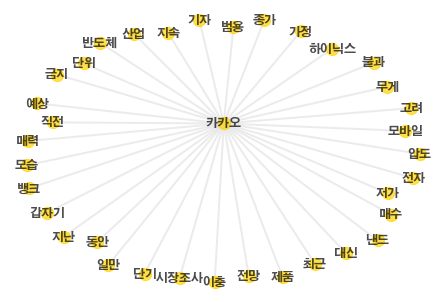

<Figure size 10800x10800 with 0 Axes>

In [66]:
relataion_analysis('카카오') ####  카카오와 연관된 단어를 조회합니다.

### 6. PoC : 추천서비스 구현

In [67]:
#### 고객정보데이터에 컬럼이름을 바꾸어줍니다.
cl_data.rename(columns = { 'Factor1':'거래참여지수' , 
                          'Factor2' : '민감도지수' , 
                          'Factor3' : '분산투자지수', 
                          'Factor4' : '성장기대지수' ,
                          'purchase_ratio' : '매수비율'}, inplace = True)

In [68]:
cl_data.loc[(cl_data['cluster']==1), 'cluster']  = '한우물개미'
cl_data.loc[(cl_data['cluster']==2), 'cluster']  = '큰손개미'
cl_data.loc[(cl_data['cluster']==3), 'cluster']  = '안정개미'
cl_data.loc[(cl_data['cluster']==4), 'cluster']  = '주린이개미'
cl_data.loc[(cl_data['cluster']==5), 'cluster']  = '한방개미'

#### 1) 추천서비스 이용 사례1 : 고객코드 A00011761

##### : 위에서 구현한 추천시스템을 활용하여 실제 거래 고객이 추천서비스를 사용했을 때를 시연해보았습니다.

In [69]:
### A00011761의 투자성향을 확인할 수 있습니다.
my_investment('A00011761')

,id,cluster,거래참여지수,민감도지수,분산투자지수,성장기대지수,매수비율,age,trade_cnt,trade_sum_p,trade_sum_amt,stck_cnt,trade_date_cnt,kospi200_ratio,firm_up_ratio,trend_beta,finance_beta
0,A00011761,주린이개미,0.047593,0.190625,0.657212,0.007633,0.583020,30.00000,87.000000,5.403912e+07,2330.000000,19.000000,24.000000,0.625526,0.368928,0.306951,-1.059827
1,cluster,주린이개미,0.144623,0.073716,1.349857,0.495708,0.556392,31.86841,96.369043,6.506573e+07,8225.320118,30.801771,21.986082,0.204123,0.523854,-0.326114,0.362577


In [70]:
#### A00011761의 거래종목을 확인합니다. 잘 알려진 종목 위주로 투자한 것을 알 수 있습니다.
data[(data['고객구분코드']=='A00011761') & (data['매도매수구분코드']==2)].groupby('상품명').sum()['총체결수량']

상품명
동국제약             1
미코             100
바디텍메드            3
바이오니아           20
삼성전기보통주         16
삼성전자보통주        340
신풍제약보통주        140
에스케이하이닉스보통주     35
엑세스바이오         270
웰크론             50
조아제약            50
진매트릭스          100
창해에탄올           50
카카오보통주          13
파미셀보통주         126
Name: 총체결수량, dtype: int64

In [71]:
#### A00011761가 '친구개미 초이스' 추천 서비스를 이용하여 종목추천을 받은 결과입니다.
Recommendation_system1('A00011761')

,종목코드,종목명,업종명,시장구분,수익성지수,성장성지수,안정성지수,활동성지수
0,245620,EDGC,기타서비스,KOSDAQ,96,79,92,64
1,084650,랩지노믹스,기타서비스,KOSDAQ,222,126,71,128
2,038290,마크로젠,기타서비스,KOSDAQ,193,80,63,64
3,118990,모트렉스,운송장비·부품,KOSDAQ,110,84,97,103
4,253840,수젠텍,의료·정밀기기,KOSDAQ,105,96,190,133
5,241840,에이스토리,오락·문화,KOSDAQ,112,123,72,187
6,307930,컴퍼니케이,금융,KOSDAQ,179,60,70,130
7,041960,코미팜,제약,KOSDAQ,113,71,50,58
8,001340,백광산업,화학,KOSPI,105,46,33,56
9,005935,삼성전자우,전기전자,KOSPI,134,95,80,76


##### :  A00011761는 잘 알려진 종목을 위주로 투자를 하였기에  비슷한 투자성향을 가진 투자자들을 기반으로 추천되었습니다. 같은 주린이개미 클러스터의 다른 투자자들의 거래종목을 기반으로 추천된 결과이므로, A00011761가 이후에 이 종목을 매수할 가능성이 높을 것입니다. 더 나아가, 추천 서비스를 통해 보다 자신이 선호하는 범위 내의 다양한 종목으로 포트폴리오를 확장할 수 있을 것으로 기대됩니다

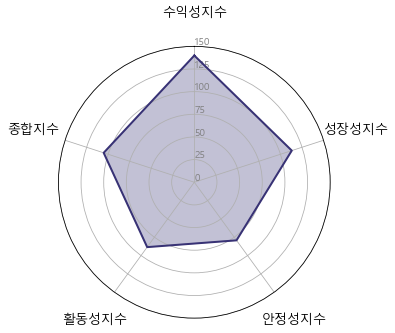

,종목코드,종목명,업종명,시장구분,수익성지수,성장성지수,안정성지수,활동성지수
0,272450,진에어,운수창고업,KOSPI,-75,-82,142,129
1,331380,유진스팩5호,금융,KOSDAQ,26,82,630,130
2,001745,SK네트웍스우,유통업,KOSPI,105,99,129,113
3,134780,화진,운송장비·부품,KOSDAQ,-84,91,317,195
4,039570,HDC아이콘트롤스,건설업,KOSPI,83,85,221,101
5,009620,삼보산업,금속,KOSDAQ,106,107,289,146
6,026940,부국철강,철강금속,KOSPI,96,79,154,122
7,194510,파티게임즈,디지털컨텐츠,KOSDAQ,-224,99,475,136
8,011810,STX,유통업,KOSPI,-36,73,266,103
9,102210,해덕파워웨이,운송장비·부품,KOSDAQ,-84,91,317,195


In [72]:
#### A00011761가 '슈퍼개미로 한걸음' 추천 서비스를 이용하여 종목추천을 받은 결과입니다.
Recommendation_system2('A00011761')

##### 포트폴리오의 안정성지수와 활동성지수가 상대적으로 부족하다고 분석되어, 추천 결과로는 안정성과 활동성지수가 높은 기업을 우선적으로 제시하여 보유 종목을 균형 있게 관리할 수 있을 것으로 기대됩니다.

#### 2) 추천서비스 이용 사례2 : 고객코드 A0001006

In [73]:
### A00011761의 투자성향을 확인할 수 있습니다.
my_investment('A0001006')

,id,cluster,거래참여지수,민감도지수,분산투자지수,성장기대지수,매수비율,age,trade_cnt,trade_sum_p,trade_sum_amt,stck_cnt,trade_date_cnt,kospi200_ratio,firm_up_ratio,trend_beta,finance_beta
0,A0001006,안정개미,-0.104530,-0.026382,0.098132,-0.894434,0.545097,20.000000,39.000000,2.863355e+06,120.000000,14.000000,9.000000,0.607522,0.086088,-2.869826,4.702487
1,cluster,안정개미,-0.070471,0.055695,-0.226522,-0.679423,0.560024,31.934666,22.905728,2.565445e+07,2288.882458,8.370823,10.396181,0.480826,0.155937,-1.056706,0.956560


In [74]:
#### A00011761의 거래종목을 확인합니다. 잘 알려진 종목 위주로 투자한 것을 알 수 있습니다.
data[(data['고객구분코드']=='A0001006') & (data['매도매수구분코드']==2)].groupby('상품명').sum()['총체결수량']

상품명
대한항공보통주         2
삼성전자1우선주       12
삼성전자보통주         9
아시아나항공 보통주      4
에스케이하이닉스보통주     1
제주항공보통주         7
진에어보통주          4
티웨이항공보통주       36
현대자동차보통주        4
Name: 총체결수량, dtype: int64

In [75]:
#### A00011761가 '친구개미 초이스' 추천 서비스를 이용하여 종목추천을 받은 결과입니다.
Recommendation_system1('A0001006')

,종목코드,종목명,업종명,시장구분,수익성지수,성장성지수,안정성지수,활동성지수
0,053980,오상자이엘,컴퓨터서비스,KOSDAQ,268,131,58,94
1,047310,파워로직스,IT부품,KOSDAQ,114,144,78,241
2,011790,SKC,화학,KOSPI,80,59,69,46
3,003495,대한항공우,운수창고업,KOSPI,148,148,87,37
4,034020,두산중공업,기계,KOSPI,80,110,78,78
5,019170,신풍제약,의약품,KOSPI,102,9,78,18
6,055550,신한지주,기타금융,KOSPI,143,62,210,186
7,071050,한국금융지주,기타금융,KOSPI,198,78,199,186
8,015760,한국전력,전기가스업,KOSPI,3,-31,45,-5
9,011210,현대위아,운수장비,KOSPI,107,80,87,90


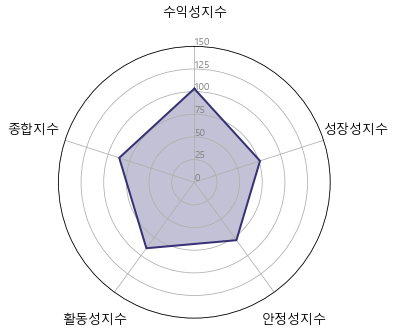

,종목코드,종목명,업종명,시장구분,수익성지수,성장성지수,안정성지수,활동성지수
0,219550,MP한강,유통,KOSDAQ,35,385,105,83
1,066110,한프,정보기기,KOSDAQ,-260,326,188,-1
2,008600,윌비스,유통업,KOSPI,86,139,102,79
3,070300,한솔시큐어,소프트웨어,KOSDAQ,91,125,108,74
4,158310,스타모빌리티,기계·장비,KOSDAQ,-184,492,225,45
5,001270,부국증권,증권,KOSPI,94,262,154,100
6,004690,삼천리,전기가스업,KOSPI,96,179,161,96
7,043710,서울리거,유통,KOSDAQ,0,144,116,42
8,111820,지와이커머스,인터넷,KOSDAQ,25,174,169,104
9,183490,엔지켐생명과학,제약,KOSDAQ,80,189,156,48


In [76]:
#### A00011761가 '슈퍼개미로 한걸음' 추천 서비스를 이용하여 종목추천을 받은 결과입니다.
Recommendation_system2('A0001006')

##### 3) 추천서비스 프로토타입핑

##### : 위에서 추천시스템을 구현한 후 추천된 결과를 가지고 추천서비스 프로토타입핑을 해보았습니다. 아래의 링크에서 확인할 수 있습니다.

#### 맞춤 추천 서비스 실행 예시 페이지 1 : https://antddunddun.netlify.app/
#### 맞춤 추천 서비스 실행 예시 페이지 2: https://antddunddunddun.netlify.app/